### Project: Mixture Density Networks
Project goals:
1. Howto implement a density Network?
2. Getting familiar with pytorch

In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torchview import draw_graph


### Overview of available Datasets on UCI

In [3]:
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

Choose dataset with id = 492

In [4]:
df = fetch_ucirepo(id=492)

In [5]:
print(type(df))

# df["date_time"]= pd.to_datetime(df["date_time"])

<class 'ucimlrepo.dotdict.dotdict'>


In [6]:
X = df.data.features.copy()
y = df.data.targets

print(X.columns.tolist())


['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'date_time']


In [7]:
print(X.shape)

(48204, 8)


### Dataset Content

In [8]:
print(df.metadata.uci_id)
print(df.metadata.num_instances)
print(df.metadata.additional_info.summary)

492
48204
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


In [9]:
print(df.variables)

                  name     role         type demographic  \
0              holiday  Feature  Categorical        None   
1                 temp  Feature   Continuous        None   
2              rain_1h  Feature   Continuous        None   
3              snow_1h  Feature   Continuous        None   
4           clouds_all  Feature      Integer        None   
5         weather_main  Feature  Categorical        None   
6  weather_description  Feature  Categorical        None   
7            date_time  Feature         Date        None   
8       traffic_volume   Target      Integer        None   

                                         description   units missing_values  
0  US National holidays plus regional holiday, Mi...    None             no  
1                             Average temp in kelvin  Kelvin             no  
2     Amount in mm of rain that occurred in the hour      mm             no  
3     Amount in mm of snow that occurred in the hour      mm             no  
4        

In [10]:
print(type(X))
print(X.head())

<class 'pandas.core.frame.DataFrame'>
  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  
0    scattered clouds  2012-10-02 09:00:00  
1       broken clouds  2012-10-02 10:00:00  
2     overcast clouds  2012-10-02 11:00:00  
3     overcast clouds  2012-10-02 12:00:00  
4       broken clouds  2012-10-02 13:00:00  


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

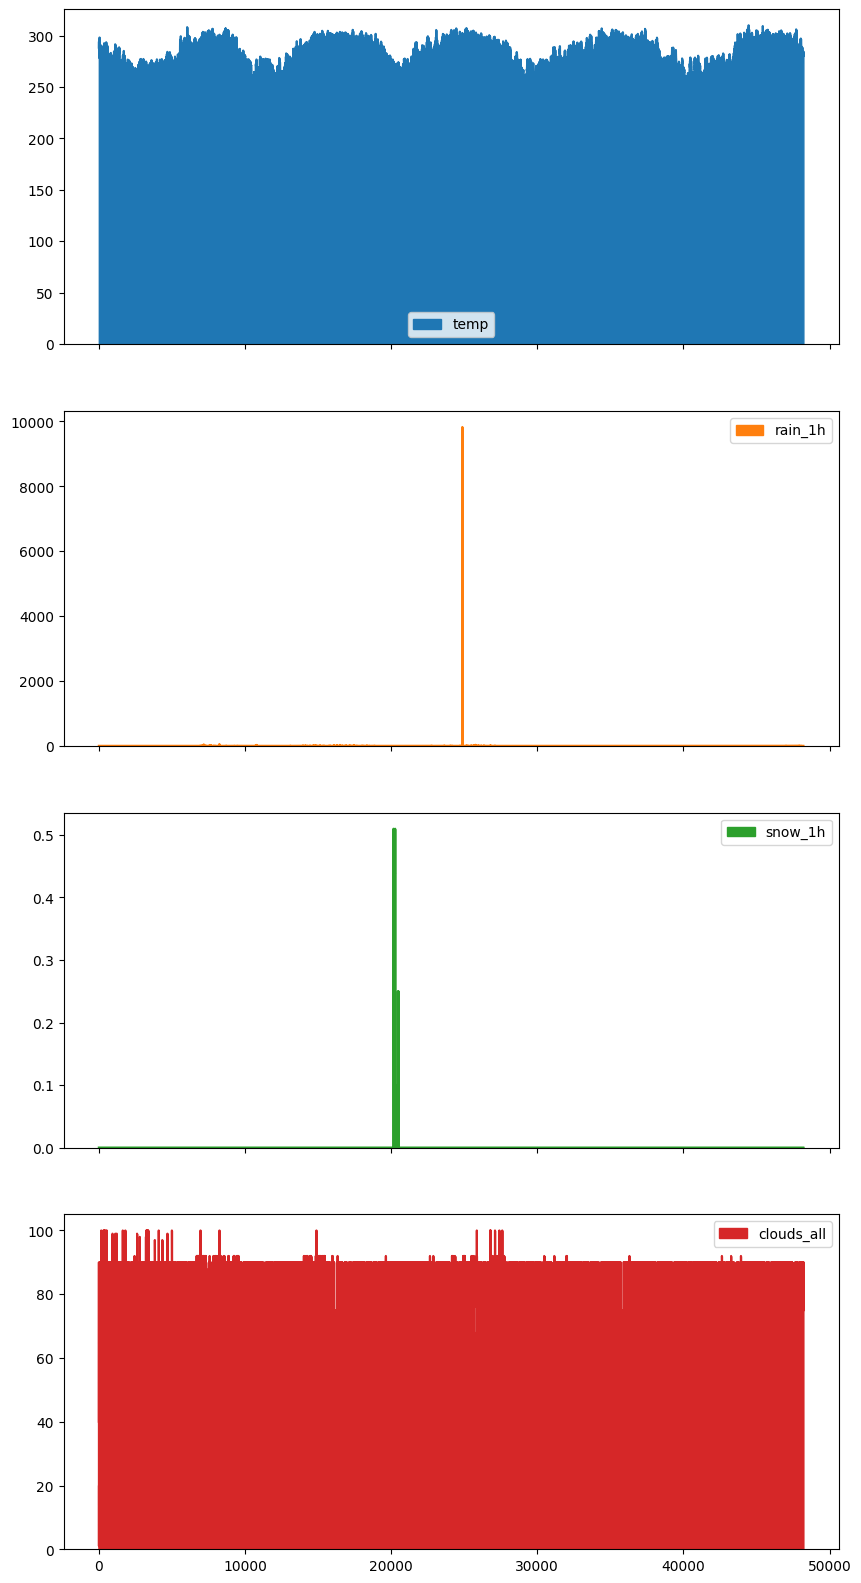

In [11]:
X.plot.area(figsize=(10,20), subplots=True)

In [12]:
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

holiday    48143
dtype: int64


### Using a cyclic Representation of time


In [13]:
X["date_time"]= pd.to_datetime(X["date_time"])

X["hour"] = X["date_time"].dt.hour
X["weekday"] = X["date_time"].dt.weekday
X["month"] = X["date_time"].dt.month

X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)

X["weekday"] = X["date_time"].dt.weekday  # Monday = 0
X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)

X["month"] = X["date_time"].dt.month
X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)

X = X.drop(columns=["hour", "weekday", "month", "date_time"])

In [14]:
X_clean = X.dropna(axis=1)
print(X_clean.shape)  
X_clean.head()  

(48204, 12)


,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,288.28,0.0,0.0,40,Clouds,scattered clouds,7.071068e-01,-0.707107,0.781831,0.62349,-0.866025,0.5
1,289.36,0.0,0.0,75,Clouds,broken clouds,5.000000e-01,-0.866025,0.781831,0.62349,-0.866025,0.5
2,289.58,0.0,0.0,90,Clouds,overcast clouds,2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5
3,290.13,0.0,0.0,90,Clouds,overcast clouds,1.224647e-16,-1.000000,0.781831,0.62349,-0.866025,0.5
4,291.14,0.0,0.0,75,Clouds,broken clouds,-2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5


In [15]:
X_clean = X_clean.drop(columns=["weather_main", "weather_description"])

In [16]:
X_clean.head()

,temp,rain_1h,snow_1h,clouds_all,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,288.28,0.0,0.0,40,7.071068e-01,-0.707107,0.781831,0.62349,-0.866025,0.5
1,289.36,0.0,0.0,75,5.000000e-01,-0.866025,0.781831,0.62349,-0.866025,0.5
2,289.58,0.0,0.0,90,2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5
3,290.13,0.0,0.0,90,1.224647e-16,-1.000000,0.781831,0.62349,-0.866025,0.5
4,291.14,0.0,0.0,75,-2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5


In [17]:

print(X_clean.shape)
print(y.shape)
print(y.head())


(48204, 10)
(48204, 1)
   traffic_volume
0            5545
1            4516
2            4767
3            5026
4            4918


### Convert Data to a useful format for PyTorch

In [18]:
X_np = X_clean.to_numpy().astype('float32')
y_np = y.to_numpy().astype('float32')


X_tensor = torch.from_numpy(X_np)
y_tensor = torch.from_numpy(y_np)

assert X_tensor.shape[0] == y_tensor.shape[0]
print(X_tensor.shape)
print(y_tensor.shape)

dataset = TensorDataset(X_tensor, y_tensor)


torch.Size([48204, 10])
torch.Size([48204, 1])


### Split Dataset to train and test

In [19]:
DATASET_SIZE = len(dataset)
SPLIT = 0.2
TEST_SIZE = int(DATASET_SIZE*0.2)
TRAIN_SIZE = DATASET_SIZE-TEST_SIZE
BATCH_SIZE = 128

In [20]:
generator = torch.Generator().manual_seed(12)

In [21]:
train_set, test_set = random_split(dataset, [TRAIN_SIZE, TEST_SIZE], generator=generator)

In [22]:
train_loader = DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


### Regression Task
Prediction of traffic volume

Define the model architecture

In [23]:
class SimpleMixtureDensity(nn.Module):
    def __init__(self,hiddenDims:list[int],headDims:list[int]):
        super().__init__()
        self.input_dim = 10
        
        sharedlist = list(zip([self.input_dim]+hiddenDims, hiddenDims))
        shared_layers = []
        mu_layers = []
        sigma_layers = []
        mu_list = list(zip([hiddenDims[-1]]+headDims, headDims))
        sigma_list = list(zip([hiddenDims[-1]]+headDims, headDims))
        
        def make_layers(listOfDims:list[tuple],listToappend:list, mod=2, lastElem=1):
            for i,a in enumerate(listOfDims):
                listToappend.append(nn.Linear(a[0],a[1]))
                if((i+1) % mod == 0 and i < len(listOfDims)-lastElem):
                    listToappend.append(nn.ReLU())
                    listToappend.append(nn.BatchNorm1d(a[1]))
        
        make_layers(sharedlist, shared_layers,lastElem=0)
        make_layers(mu_list, mu_layers, mod=1)
        make_layers(sigma_list,sigma_layers, mod=1)
        
        self.shared_layers = nn.Sequential(*shared_layers)
        self.mu_layers = nn.Sequential(*mu_layers)
        self.sigma_layers = nn.Sequential(*sigma_layers)
    def forward(self, input):
        shared_out = self.shared_layers(input)
        mu = self.mu_layers(shared_out)
        sigma = self.sigma_layers(shared_out)
        sigma = F.softplus(sigma)+1e-6
        return mu,sigma


(dot.exe:8528): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


SimpleMixtureDensity(
  (shared_layers): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): Linear(in_features=5, out_features=5, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mu_layers): Sequential(
    (0): Linear(in_features=5, out_features=4, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=4, out_features=3, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=3, out_features=2, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_runn

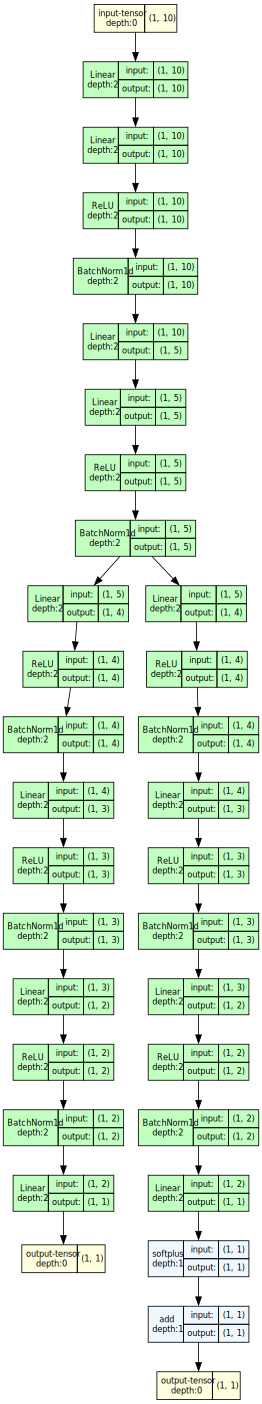

In [ ]:
model = SimpleMixtureDensity([10,10,5,5],[4,3,2,1])
print(model)
model.eval()
graph = draw_graph(
    model, 
    input_size=(1,10),          
    expand_nested=False,          
    graph_name="SimpleMixtureDensity",
    save_graph=False,            
    roll=True,                  
    depth=10,                    
    show_shapes=True             
)

graph.visual_graph  
